# CAB420, DCNNs, Bonus Example: DCNNs and Audio Data
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* ~~There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.~~ Actually, there is a TL;DR section here as I've moved this from the main content into the bonus content.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

This example looks at using audio data with a deep convolutional neural network. We're using a dataset broadly similar in size to our image examples. We'll look at two approaches to use audio data:
* Converting audio to an image, and then using a regular 2D CNN
* Leaving the audio as a 1D signal, and using a 1D CNN

As we'll see, the 1D CNN looks much like a 2D CNN, with just a change in name. There are a number of other things that can be done with audio (and other 1D signal data such as bio-medical signals) that are beyond the scope here, but further improve performance. Interested students are encouraged to look into SincNet layers as a replacement for the first 1D CNN layer.

This example is heavily based on this [tensorflow example](https://www.tensorflow.org/tutorials/audio/simple_audio).

### Too Long; Didn't Read:

Processing audio data does not require a huge change in thinking from what we do with images. The most notable differences are:
* in the pre-processing, in that now we need to load audio data, and operations such as cropping and resampling are different in the audio domain
* in the visualisation of the data, as we now can't easily look at pictures, but rather need to listen to audio files to work out what's going on.

The actual network structure itself is really very similar to what we're used to with images. Particularly if our pre-processing involves converting the audio into an image representation. If we leave the data as a 1D signal (i.e. as it actually is), then we can just change operations like our 2D CNN and 2D Pooling into 1D operations. One big difference of note here is that we will often have much larger filter dimensions in our 1D networks as our samples are much larger in the single dimension than we typically see in an image.

### Where does this fit into all the other CAB420 content?

This really fits alongside the first and second DCNN examples that play with images, and can be seen as an extension of this content. Really, we're looking at how the ideas in those example fit with audio data (or any other 1D signal). 

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import keras
from keras import layers
from keras import models
from IPython import display

from sklearn.metrics import confusion_matrix

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.config.optimizer.set_jit(False)

2024-01-06 01:34:17.845103: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 01:34:17.845156: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 01:34:17.845171: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## The Data

We're using the mini speech commands dataset. This is a dataset we can access through the tensorflow API that contains samples of 8 sample speech commands:
* right
* yes
* left
* down
* go
* no
* up
* stop

Each command has 1000 samples, and each file lasts for 1 second (or very close to). Audio is sampled at 16 kHz, meaning each sample is 16,000 in length. If we think about our MNIST datasets, we have images that were $28x28$, so we have much larger samples here.

There is also a larger dataset with about 30 commands, but for the sake of size and being able to run this quickly, we'll stick to the small version.

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Commands: ['stop' 'left' 'yes' 'up' 'down' 'right' 'go' 'no']
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/left/f2b8fc18_nohash_1.wav', shape=(), dtype=string)


We'll split our data into train, validation and testing. 80% will go into training, with 10% into validation and testing.

In [3]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Dealing with Audio

We're going to use some functions in the tensorflow API to decode our audio. We have
* A function, decode_audio, to load the audio file. This will also provide a bit of mild pre-processing to fit the data into the range [-1 .. +1]
* A function, get_label, to extract the label for the sample. We're exploiting the structure of the data, where each class is in it's own directory.
* A function, get_waveform_and_label, which given a filename will return the extracted waveform and label

We'll the test those by pulling out and visualising some samples.

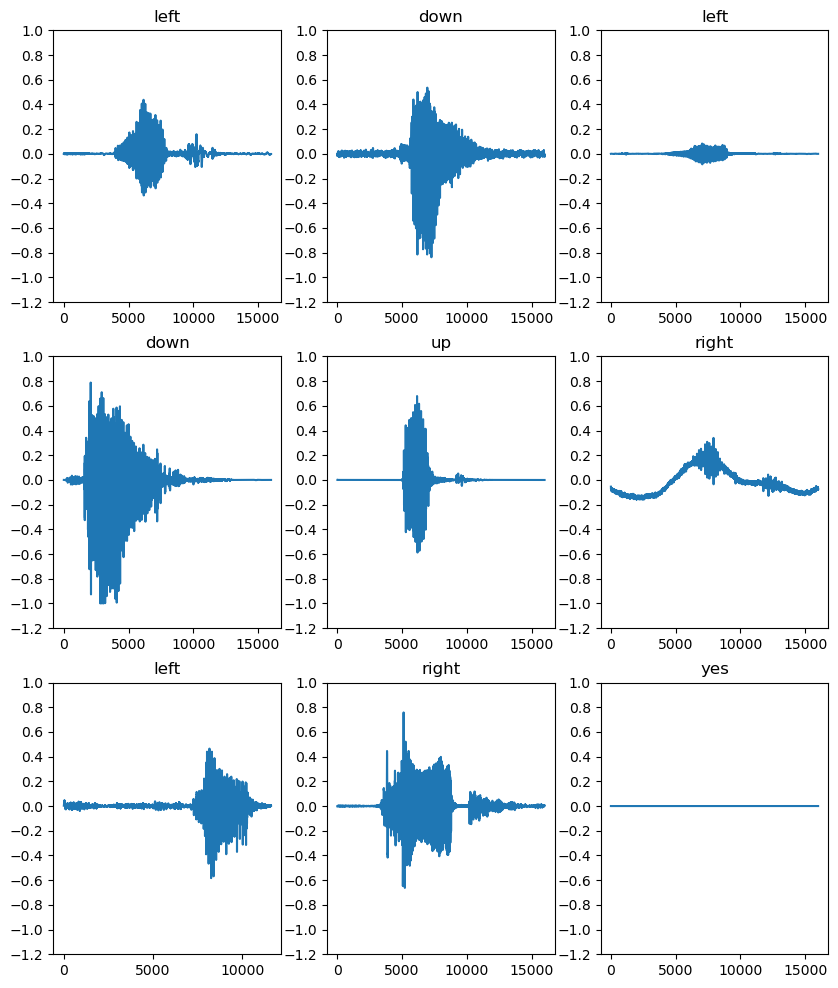

In [4]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

We'll also visualise the audio. While this is clearly less intuitive than visualising images of clothing, it nonetheless is a good sanity check in terms of making sure that we actually have data being loaded properly.

## Audio as Images

This may feel like cheating, but it's actually really common in audio tasks. We're going to convert our audio into an image in the form of a spectogram. There are a few reasons why this is a popular method:
* ImageNet: ImageNet is a very large image dataset which helped to kick start the deep learning madness. For a long time, there was not an equivilent large scale audio (or 1D signal) dataset. As such, in order to leverage the power of ImageNet and have enough data to exploit deep learning, converting audio into an image was seen as a very good option (and it's still very common)
* Frequency Information: The majority of audio processing and machine learning on audio prior to deep learning used frequency information. This involved techniques such as Fourier transforms, or extraction of frequency features such as Mel-Frequency Ceptral Coefficients (MFCCs). While these don't necessarily result in images - they can. We can get spectorgrams, which provide a frequency representation of the signal; or we can also pack MFCCs into an image.

In our case, we'll use spectrograms, which we can pull out through tensorflow. These apply a short-time fourier transform, which computes a fourier transform for small slices of the audio, and stacks these into an image. Thus we retain some time information, while also pulling out frequency data.

In [5]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

We'll now pull out an audio file, and look at the spectrogram for it.

In [6]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


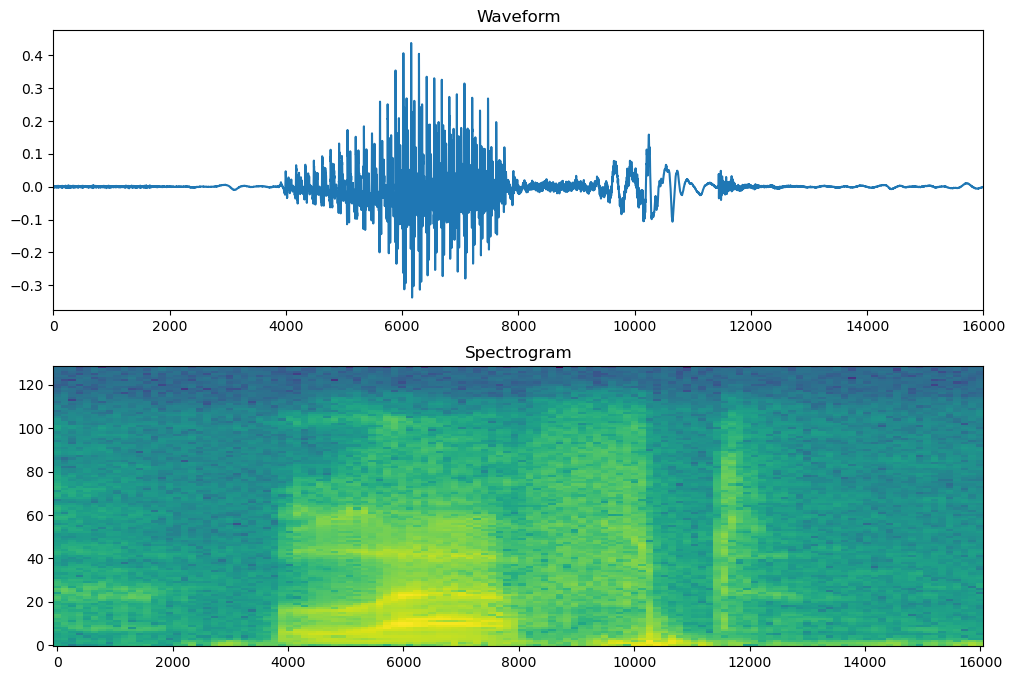

In [7]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

## Data Setup

We can load audio files and convert them to a spectrogram, we now need to setup our data to load into the model with the labels. We'll create a function that returns the spectrogram and label_id given an audio file and text label.

In [8]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

We'll now visualise a few samples to see if it's working. Again, this is perhaps not as easy to interpret a regular image, but it's still a good sanity check.

/tmp/ipykernel_777069/524235750.py:19: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


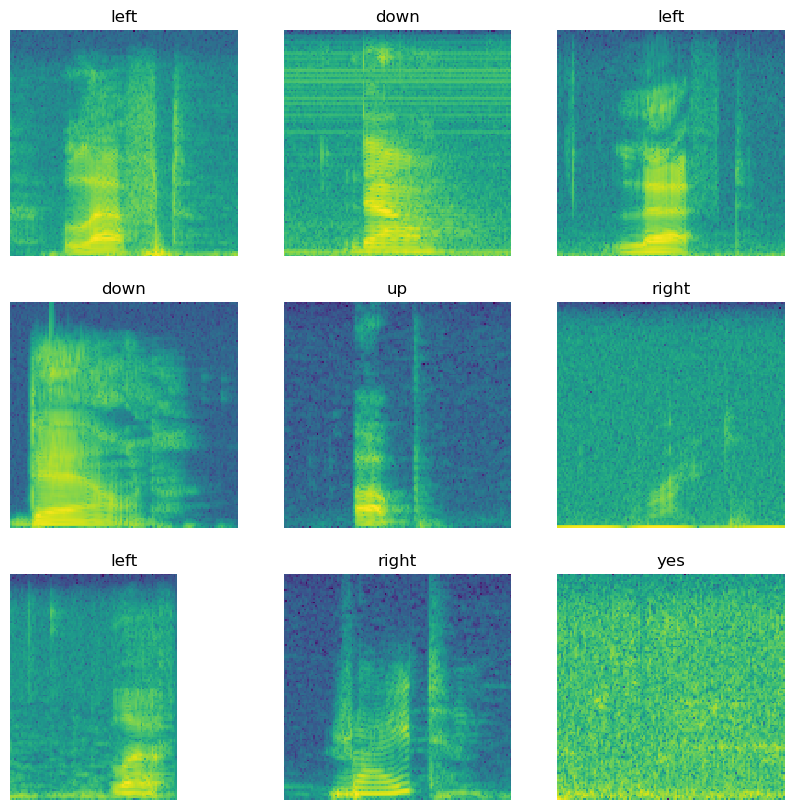

In [9]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

Finally we'll create a function to load our entire dataset, and then use that to load up our training, validation and testing data.

In [10]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

## Network Setup

We'll now setup our network. This is doing to look a lot like our earlier CNNs. Before we go too far we'll pull out the input size and number of classes from the data.

In [11]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (124, 129, 1)


We're then going to create a normalisation layer, which we want just to do a bit of data cleaning to help ensure that the data is consistent, which will help training.

This normalisation layer will normalise each pixel by it's mean and standard deviation, so prior to doing to this we need to calculate the means and standard deviations to use for normalisation. Hence we use the adapt function and our data to setup our normalisation.

In [12]:
norm_layer = layers.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

Building the network then, we'll start with:
* Our input layer, using the shape we extracted earlier
* Two pre-processing layers, a resize to shrink our data (to make things quicker to train), and a normalisation layer
* Two 2D convolutions followed by max-pooling layers
* A dense layer
* A final output layer for classification

In [13]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)         │          3 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)        │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 2304)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    295,040 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 8)                 │      1,032 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 314,891 (1.20 MB)

 Trainable params: 314,888 (1.20 MB)

 Non-trainable params: 3 (16.00 B)

Model compilation and training is then the same as we've been doing. Note that one difference we have here is the use of early stopping, i.e., this bit: `callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=2)`

What this is going to do is train until we have 2 epochs in a row where the validation loss does not improve. If we set `patience` to something bigger, training needs to flatten out for longer before it stops. 

In [14]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'], jit_compile=False
)

num_epochs = 40
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=num_epochs,
    callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.2118 - loss: 2.0086 - val_accuracy: 0.5300 - val_loss: 1.5553
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4574 - loss: 1.5525 - val_accuracy: 0.6562 - val_loss: 1.1676
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5571 - loss: 1.2345 - val_accuracy: 0.7063 - val_loss: 0.9614
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6543 - loss: 1.0139 - val_accuracy: 0.7350 - val_loss: 0.8422
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6759 - loss: 0.9100 - val_accuracy: 0.7650 - val_loss: 0.7497
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7161 - loss: 0.8092 - val_accuracy: 0.7763 - val_loss: 0.7176
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7421 - loss: 0.7417 - val_accuracy: 0.7937 - val_loss: 0.6408
Epoch 8/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7693 - loss: 0.6650 - val_accuracy: 0

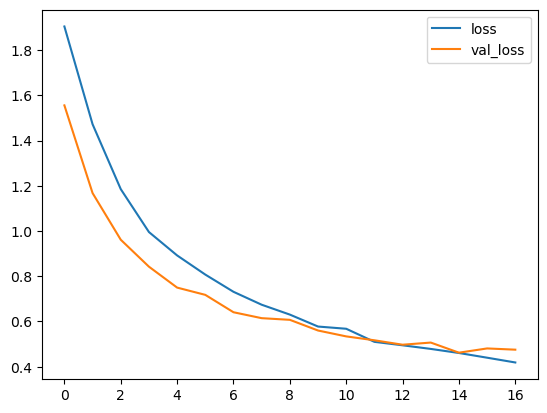

In [15]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Accuracy wise, our model is pretty good. Unsurprisingly, we see the most confusion between "go" and "no".

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Test set accuracy: 85%


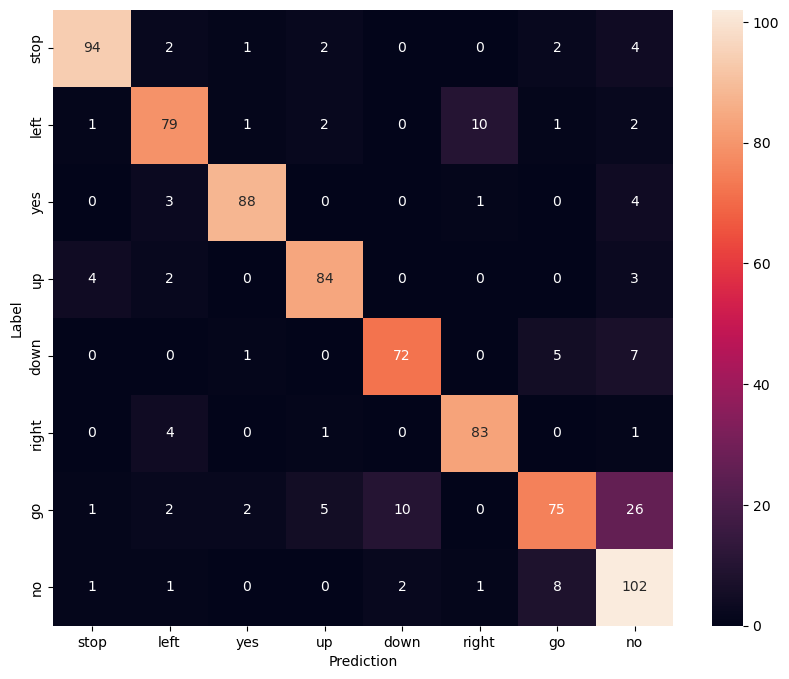

In [16]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Audio as Audio

Now, we'll actually leave our audio as an audio signal. We'll re-create our data loaders now to load the data as an audio signal. There are a couple of other things that we'll do:
* Pad the signals to be a consistent length. We noted earlier that most samples are of length 16,000. A few are just a bit shorter. We'll pad all samples up to length 16,000 as we need our data to be in the same shape. This issue of having consistent length/size data is a common one in ML; the vast majority of methods expect data of a consistent size.
* ~~We'll resample the signals. In this case we'll resample the files down to 6 kHz. This means we're losing some high frequency information (human speech typically extends up to 8 kHz, which means we need to sample at 16 kHz to capture all the speech content). This is being done simply to help keep the network a bit smaller and to avoid needing filters that are very huge, or having too many layers.~~

~~The resample is the audio equivilent of a resize in the image domain - but this is not the same as resizing the spectrogram. With the resample, we discard high frequency information. The spectrogram tranform gives us a frequency based representation. Resizing this does not discard the high frequency information from the audio domain, rather it limits our (and the networks) ability to deal with nearby frequency bands. (just to add to confusion, this image resize is throwing away high frequency image information).~~

~~We can kind of think of this as meaning that:~~
* ~~Our image representation captures a coarse representation of the whole frequency spectrum~~
* ~~Our audio representation captures all of the information at frequencies of 3 KhZ and below~~

I used to have that resample in there, and then I removed it. This was not becuase the resample was a bad idea - through throwing away high frequency information is not ideal - but rather because the tensorflow_io library that was doing that was having an issue or two with the more recent versions of keras and tensorflow. A solution to this would be to move to using librosa for the audio processing pipeline, though I have obviously not yet done this. 

In [17]:
def dynamic_padding(inp, min_size):
    pad_size = min_size - tf.shape(inp)[0]
    paddings = [[0, pad_size]]
    return tf.pad(inp, paddings)

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  #
  # Resampling would go here
  #
  waveform = tf.cond(tf.less(tf.shape(waveform)[0], 16000), true_fn=lambda: dynamic_padding(waveform, 16000), false_fn=lambda: waveform)
  waveform = tf.expand_dims(waveform, -1)
  waveform = tf.ensure_shape(waveform, (16000,1))
  label_id = tf.argmax(label == commands)
  return waveform, label_id

AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = waveform_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

for waveform, _ in waveform_ds.take(1):
  input_shape = waveform.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = layers.Normalization()
norm_layer.adapt(waveform_ds.map(lambda x, _: x))

Input shape: (16000, 1)


We'll now create our network. The biggest change is the shift from 2D convolution layers to 1D. You will also note that we have much bigger filter sizes. There are two intertwined reasons for this:
* The one dimension of our data is much bigger than either of them were with in the image version, and as we want each filter to be able to see a meaninful amount of the signal, we need a larger filter
* We want to keep the network shallow to speed/simplicity. If we went deeper, we could use small filters and trust the stacking of convolution layers (and max-pools) would increase our receptive field size (see the next lot of DCNN lecture notes for information on what this means)

In [18]:
model = models.Sequential([
    layers.Input(shape=(input_shape[0],1)),
    norm_layer,
    layers.Conv1D(32, 15, activation='relu'),
    layers.MaxPooling1D(pool_size=4, strides=4),
    layers.SpatialDropout1D(0.25),
    layers.Conv1D(64, 11, activation='relu'),
    layers.MaxPooling1D(pool_size=4, strides=4),
    layers.SpatialDropout1D(0.25),
    layers.Conv1D(64, 7, activation='relu'),
    layers.MaxPooling1D(pool_size=2, strides=2),
    layers.SpatialDropout1D(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 16000, 1)          │          3 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d (Conv1D)                 │ (None, 15986, 32)         │        512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3996, 32)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout1d               │ (None, 3996, 32)          │          0 │
│ (SpatialDropout1D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3986, 64)          │     22,592 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 996, 64)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout1d_1             │ (None, 996, 64)           │          0 │
│ (SpatialDropout1D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_2 (Conv1D)               │ (None, 990, 64)           │     28,736 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 495, 64)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout1d_2             │ (None, 495, 64)           │          0 │
│ (SpatialDropout1D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 31680)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │  4,055,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 8)                 │      1,032 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 4,108,043 (15.67 MB)

 Trainable params: 4,108,040 (15.67 MB)

 Non-trainable params: 3 (16.00 B)

Our model has substantially more parameters than the previous one we had with images. We'll train the model in much the same way.

In [19]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'], jit_compile=False
)

num_epochs = 40
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=num_epochs,
    callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.1430 - loss: 2.1504 - val_accuracy: 0.2175 - val_loss: 2.0390
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.2145 - loss: 2.0114 - val_accuracy: 0.3363 - val_loss: 1.8988
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.2853 - loss: 1.9190 - val_accuracy: 0.3950 - val_loss: 1.7216
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3782 - loss: 1.7249 - val_accuracy: 0.4650 - val_loss: 1.5825
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.4485 - loss: 1.5269 - val_accuracy: 0.5462 - val_loss: 1.3572
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5272 - loss: 1.3658 - val_accuracy: 0.5750 - val_loss: 1.2578
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5756 - loss: 1.2248 - val_accuracy: 0.6112 - val_loss: 1.1899
Epoch 8/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6279 - loss: 1.0999 - val_acc

During training, one thing we can see is that our model is much slower to train - in part this is the large number of parameters, but not entirely.

In terms of speed, not all parameters are equal. Convolution layers are slower than dense layers, and the size of the input has a big impact on the speed of convolution layers. While each of our 1D conv filters has a broadly similar number of parameters to our image based approach, the input object is much larger, meaning there are many more windows to which the filter is applied; so while each application may not be much different in speed, there are many more windows to slide the filter over.

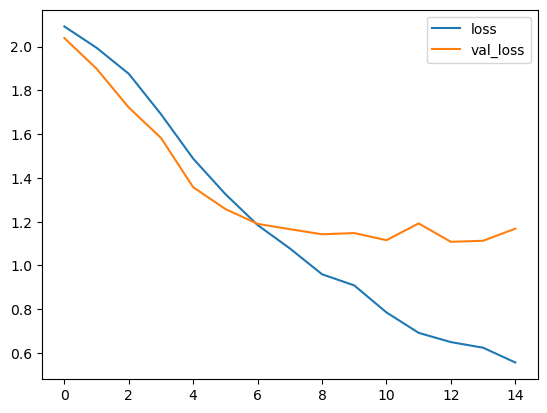

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test set accuracy: 64%


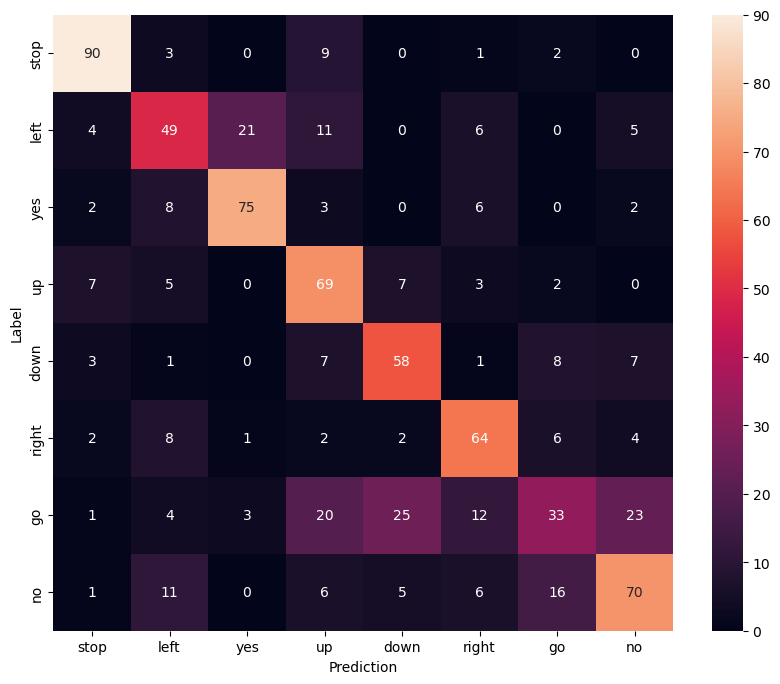

In [20]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

We also see our performance is a little worse here, though the patterns of errors observed in the confusion matrix are different.

In terms of why our model is worse, there are a few things at play here:
* ~~We have downsampled our signal, throwing away all data above 3 kHz. Avoiding the downsampling would help this, but we'd need bigger filters/a deeper network with the larger signal.~~
* Our receptive field is not as big in the audio network as the video one (i.e. in the last conv layer, each filter "sees" more of the input signal in the video version). A deeper network (or larger filters) would help here.
  * This is made even worse by not downsampling the signal (though that does preserve high frequency information)
* Larger filters are harder to learn than smaller filters, there are more possible shapes that they can take and many of these shapes may not be meaningful.
* The frequency representation used in the image version of the signal is a really good representation, which pulls out key information that the network can then build on. It's hard to 1D filters to learn to replicate this (though SincNet layers, which are a learned band-pass filter, are excellent at this)

If we wanted to push our network using the audio data to new levels of performance, a suggested approach would be:
* Use a SincNet layer in the first layer, prior to the 1D Convolutions.
* Play with the ressampling. 16 kHz is more than likely overkill, but we'd like to keep some high frequency info. 8 KhZ is perhaps where I'd start. Silence at the front and back of audio samples could also be trimmed to reduce sample size and making model training quicker.
* Increase network depth, and try playing the filter sizes. These are, at present, unlikely to be optimal.

## Final Thoughts

So what have we learned today?

We can apply deep nets to audio in much the same way that we do images. We can either turn our audio into images and do **exactly** the same thing, or leave the data as audio and turn 2D operations into 1D operations, such that we do **very nearly** the same thing. Either way, not much changes.

As noted above, there are other options we have with audio data such as SyncNet filters and various other variations on layers, but fundamentally the processes are very similar. Along the same lines, we can extend networks to videos or range (i.e. 3D) data by using 3D convolution and pooling operations, though these are very computionally demanding. We can also use these sort of 1D approaches on other signal data, such as biomedical signals (i.e. EGCs, PCGs, EEGs). Often these signals are sampled at much lower rates than human speech too, so the challenges that we see with network depth and filter width are less of a problem.